# Tutorial - 3

- Name : Satheesh D M

- Roll No: MA24M023

### Instruction:
- Complete the Canny edge detection by writing the non-maxima seperation and hysterisis code.

- Complete the Harris corner detection by filling in the harris response function.

- Use different values of sigma and plot your output (I have written the code for a particular sigma)

- Try seeing what would happen if you do not blur before finding edges/corners.

- Use different cells for each of these experiments. Download your final notebook with all cells giving visble output and comment your code so that it is explainable.


## Canny edge detector 

In [ ]:
# Library imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, convolve

# Helper functions
def rgb2gray(image):
    """Convert RGB image to grayscale."""
    return np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])

def sobel_filters(image):
    """Compute Sobel gradients."""
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    Gx = convolve(image, Kx)
    Gy = convolve(image, Ky)

    G = np.hypot(Gx, Gy)  # Gradient magnitude
    theta = np.arctan2(Gy, Gx) * (180.0 / np.pi) % 180  # Convert to 0-180 degrees

    return G, theta

def non_maximum_suppression(gradient, theta):
    """Apply Non-Maximum Suppression with subpixel interpolation."""
    M, N = gradient.shape
    suppressed = np.zeros((M, N), dtype=np.float32)

    # Define angle bins for discretization
    angle_bins = np.array([0, 22.5, 67.5, 112.5, 157.5, 180])
    direction = np.digitize(theta, angle_bins) - 1

    for i in range(1, M - 1):
        for j in range(1, N - 1):
            # Get neighboring pixels using subpixel interpolation
            if direction[i, j] in [0, 4]:  # Horizontal (0°)
                q = gradient[i, j + 1]
                r = gradient[i, j - 1]
            elif direction[i, j] == 1:  # Diagonal (45°)
                q = gradient[i + 1, j - 1]
                r = gradient[i - 1, j + 1]
            elif direction[i, j] == 2:  # Vertical (90°)
                q = gradient[i + 1, j]
                r = gradient[i - 1, j]
            else:  # Diagonal (135°)
                q = gradient[i - 1, j - 1]
                r = gradient[i + 1, j + 1]

            # Subpixel interpolation
            subpixel_q = (q + r) / 2.0

            # Suppress non-maximum pixels
            if gradient[i, j] >= subpixel_q:
                suppressed[i, j] = gradient[i, j]

    return suppressed

def threshold(image, low, high):
    """Apply double thresholding."""
    strong = 255
    weak = 75

    strong_i, strong_j = np.where(image >= high)
    weak_i, weak_j = np.where((image <= high) & (image >= low))

    output = np.zeros_like(image, dtype=np.uint8)
    output[strong_i, strong_j] = strong
    output[weak_i, weak_j] = weak

    return output, strong, weak

def hysteresis(image, strong, weak):
    """Apply edge tracking by hysteresis with an 8-neighborhood approach."""
    rows, cols = image.shape
    output = image.copy()

    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            if output[i, j] == weak:
                # Check if any of the 8 neighbors is a strong edge
                if (strong in output[i-1:i+2, j-1:j+2]):
                    output[i, j] = strong  # Promote weak edge to strong
                else:
                    output[i, j] = 0  # Suppress weak edge

    return output

def canny_edge_detection(image, sigma=1.4, low=20, high=40):
    """Full Canny Edge Detection Pipeline."""
    gray = rgb2gray(image)
    blurred = gaussian_filter(gray, sigma)
    gradient, theta = sobel_filters(blurred)
    suppressed = non_maximum_suppression(gradient, theta)
    thresholded, strong, weak = threshold(suppressed, low, high)
    final_edges = hysteresis(thresholded, strong, weak)

    return final_edges

###########################################
### CUSTOM FUNCTION FOR DIFFERENT SIGMA ###
###########################################
def canny_different_sigma(image, sigma):
    edges = canny_edge_detection(image, sigma)

    # Show results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(edges, cmap='gray')
    plt.title(f"Canny Edge Detection, $\sigma = {sigma}$")
    plt.axis("off")

    plt.show()

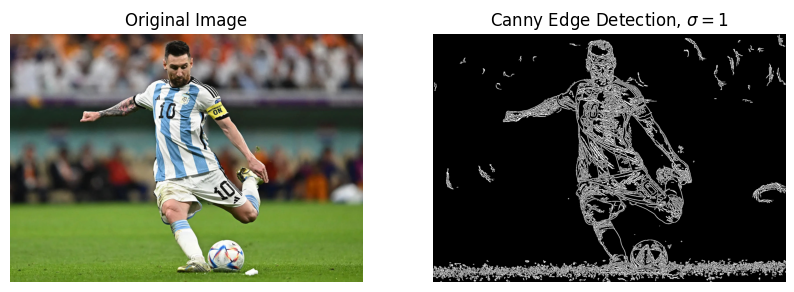

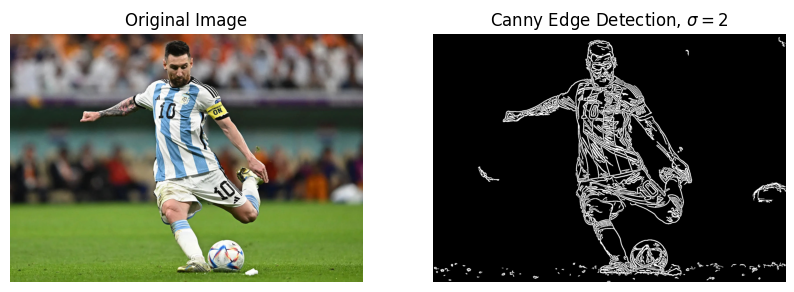

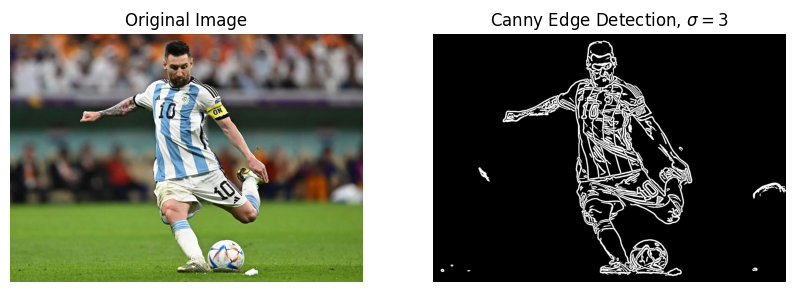

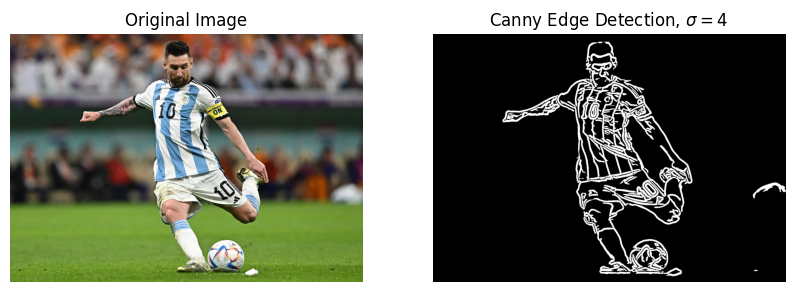

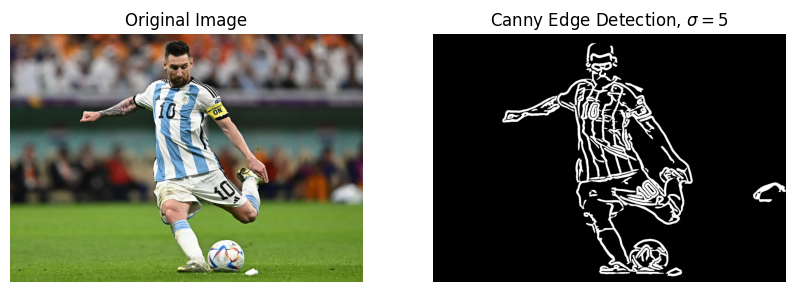

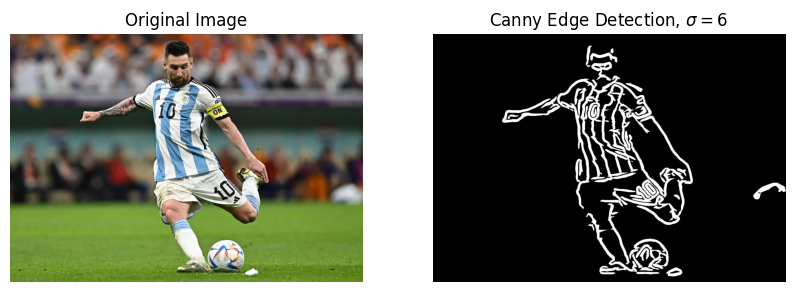

In [2]:
# Experiments for different sigma
# Load an example image
image = plt.imread('example_canny.jpg')

for i in range(1, 7):
    canny_different_sigma(image, i)



## Harris Corner Detector

In [3]:
# Helper codes
def compute_gradients(image):
    """Compute gradients using Sobel filters."""
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    Ix = convolve(image, Kx)
    Iy = convolve(image, Ky)

    return Ix, Iy

############################
### HARRIS RESPONSE FUNC ###
############################
def harris_response(image, sigma=1.0, k=0.04):
    """Compute Harris corner response."""
    Ix, Iy = compute_gradients(image)

    # Compute products of gradients
    Ixx = gaussian_filter(Ix**2, sigma)
    Iyy = gaussian_filter(Iy**2, sigma)
    Ixy = gaussian_filter(Ix * Iy, sigma)

    # Compute determinant and trace of the structure tensor
    det_M = (Ixx * Iyy) - (Ixy**2)
    trace_M = Ixx + Iyy

    # Compute Harris response
    R = det_M - k * (trace_M**2)

    return R

def non_maximum_suppression(R, threshold):
    """Apply non-maximum suppression to keep only strong corners."""
    corner_map = np.zeros_like(R)
    corner_map[R > threshold] = 255
    return corner_map

def harris_corner_detection(image, sigma=1.0, k=0.04, threshold=1e-3):
    """Full Harris Corner Detection Pipeline."""
    gray = rgb2gray(image)
 
    R = harris_response(gray, sigma, k)
    corners = non_maximum_suppression(R, threshold * R.max())
    return corners

###########################################
### CUSTOM FUNCTION FOR DIFFERENT SIGMA ###
###########################################
def harris_different_sigma(image, sigma):
    corners = harris_corner_detection(image, sigma)

    # Show results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(image, cmap='gray')
    y, x = np.where(corners > 0)  # Ensure correct order (x, y)
    plt.scatter(x, y, color='red', s=1)  # Scatter expects (x, y)
    plt.title(f"Harris Corner Detection, $\sigma = {sigma}$")
    plt.axis("off")

    plt.show()

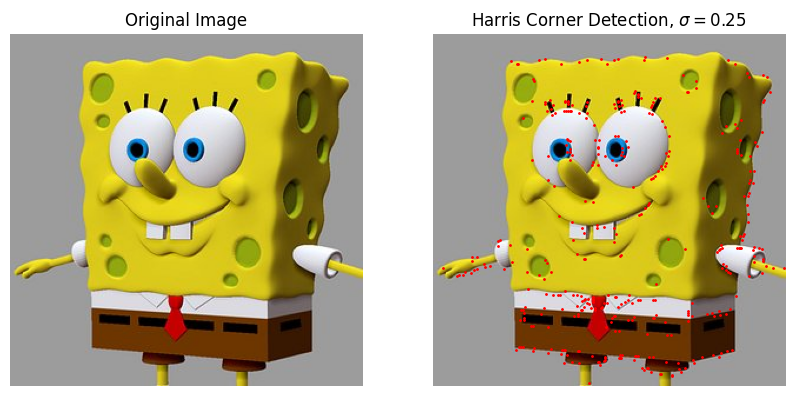

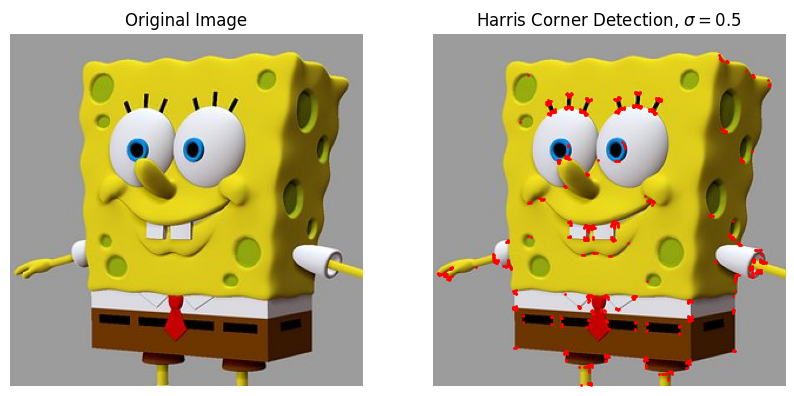

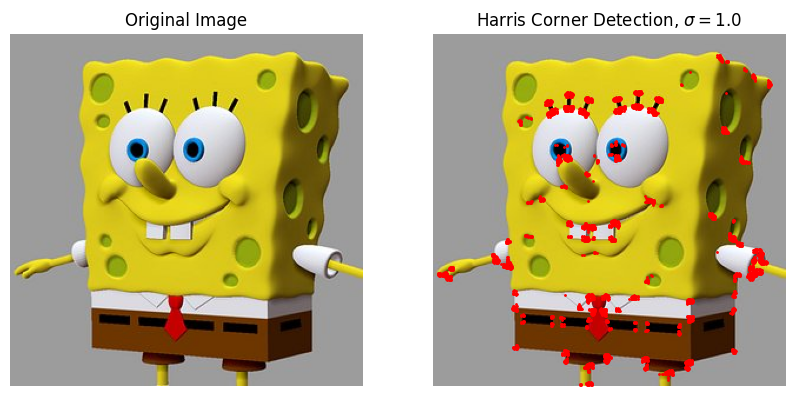

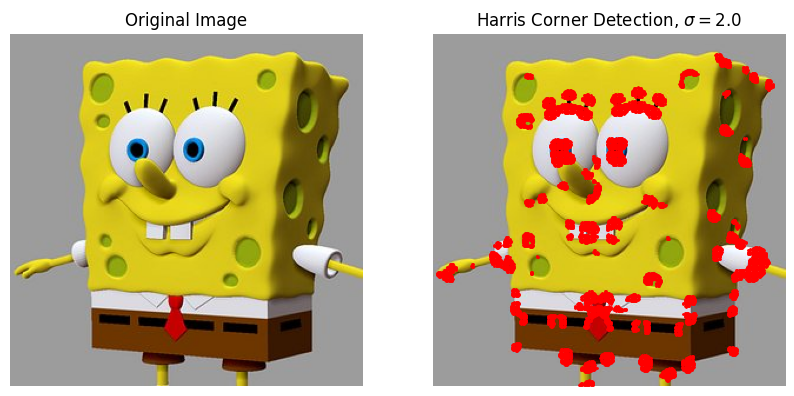

In [4]:
# experiments for different sigma
# Load an example image
image = plt.imread('example_harris.jpg')

harris_different_sigma(image, 0.25)
harris_different_sigma(image, 0.5)
harris_different_sigma(image, 1.0)
harris_different_sigma(image, 2.0)

## NO BLURRING

### Canny edge detector
The Sobel filter has in built blurring. Though it is not sufficient hence the additional blurring is used in the process.

- Without additional burring the filter doesn't capture the proper edges and captures background noise.

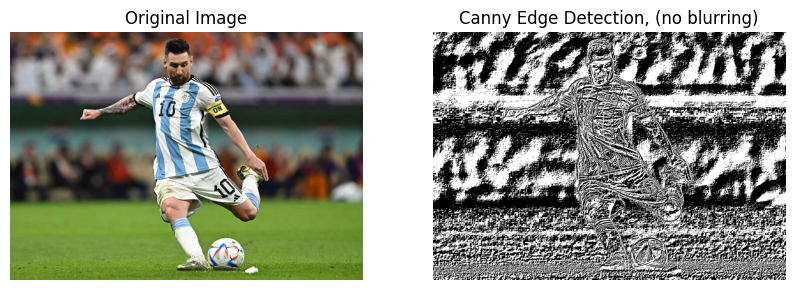

In [5]:
# Witthout gaussian blurring
def canny_edge_no_blurr(image, low=20, high=40):
    """Full Canny Edge Detection Pipeline without Gaussian blur."""
    gray = rgb2gray(image)
    gradient, theta = compute_gradients(gray)
    suppressed = non_maximum_suppression(gradient, theta)
    thresholded, strong, weak = threshold(suppressed, low, high)
    final_edges = hysteresis(thresholded, strong, weak)

    return final_edges

# Load an example image
image = plt.imread('example_canny.jpg')


edges = canny_edge_no_blurr(image)

# Show results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title(f"Canny Edge Detection, (no blurring)")
plt.axis("off")

plt.show()

### Harris corner detection without blurring

- It is not detecting any corner for the selected sample image.  When the Gaussian blur in Harris corner detection is removed, no corners may be detected because the gradients become highly sensitive to noise.

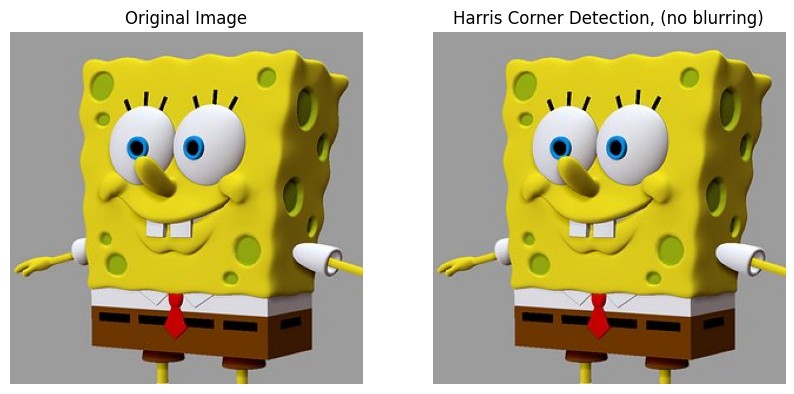

In [ ]:
# Helper functions
def rgb2gray(image):
    """Convert RGB image to grayscale."""
    return np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])

def compute_gradients(image):
    """Compute gradients using Sobel filters."""
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    Ix = convolve(image, Kx)
    Iy = convolve(image, Ky)

    return Ix, Iy

def harris_response_no_blur(image, k=0.04):
    """Compute Harris corner response without blurring."""
    Ix, Iy = compute_gradients(image)

    # Compute products of gradients without blurring
    Ixx = Ix**2
    Iyy = Iy**2
    Ixy = Ix * Iy

    # Compute determinant and trace of the structure tensor
    det_M = (Ixx * Iyy) - (Ixy**2)
    trace_M = Ixx + Iyy

    # Compute Harris response
    R = det_M - k * (trace_M**2)

    return R

def non_maximum_suppression(R, threshold):
    """Apply non-maximum suppression to keep only strong corners."""
    corner_map = np.zeros_like(R)
    corner_map[R > threshold] = 255
    return corner_map

def harris_corner_detection_1(image, k=0.04, threshold=1e-3):
    """Full Harris Corner Detection Pipeline without blurring."""
    gray = rgb2gray(image)
 
    R = harris_response_no_blur(gray, k)
    corners = non_maximum_suppression(R, threshold * R.max())
    return corners

image = plt.imread('example_harris.jpg')
corners = harris_corner_detection_1(image)

# Show results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(image, cmap='gray')
y, x = np.where(corners > 0)  # Ensure correct order (x, y)
plt.scatter(x, y, color='red', s=1)  # Scatter expects (x, y)
plt.title(f"Harris Corner Detection, (no blurring)")
plt.axis("off")

plt.show()
